# Exploratory analysis of time series trace
This notebook examines a time series, in the form of an Obspy trace, to examine the data and its properties for the purpose of identifying a metric of the data and using it to assign uncertainties to autopicked events (utilized in the **sigpig.core.data** *process_autopicked_events* function). 

In [1]:
# load a file containing a dict describing the top 430 autopicked events (events w/ > 22 phases) on 03/13/2018
import pickle
infile = open(f'top_events_dict.pkl', 'rb')
events_dict = pickle.load(infile)
infile.close()

# save the dict keys (hashed event ids) into a list for easy access
event_ids = list(events_dict.keys())

/Users/human/opt/anaconda3/envs/sigpig/lib/python3.6/site-packages/pyproj/__init__.py:76: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
# define the event to inspect as an index into event_ids
event = events_dict[event_ids[0]].copy()

# print the list of dicts to see the phases that make up this event
import pprint
pprint.pprint(event)

[{'station': '1.DP1', 'time': UTCDateTime(2018, 3, 13, 0, 2, 49, 912000)},
 {'station': '2.DP1', 'time': UTCDateTime(2018, 3, 13, 0, 2, 49, 852000)},
 {'station': '3.DP1', 'time': UTCDateTime(2018, 3, 13, 0, 2, 49, 932000)},
 {'station': '4.DP1', 'time': UTCDateTime(2018, 3, 13, 0, 2, 49, 868000)},
 {'station': '5.DP1', 'time': UTCDateTime(2018, 3, 13, 0, 2, 49, 876000)},
 {'station': '6.DP1', 'time': UTCDateTime(2018, 3, 13, 0, 2, 49, 892000)},
 {'station': '7.DP1', 'time': UTCDateTime(2018, 3, 13, 0, 2, 49, 908000)},
 {'station': '8.DP1', 'time': UTCDateTime(2018, 3, 13, 0, 2, 49, 872000)},
 {'station': '9.DP1', 'time': UTCDateTime(2018, 3, 13, 0, 2, 49, 892000)},
 {'station': '10.DP1', 'time': UTCDateTime(2018, 3, 13, 0, 2, 49, 860000)},
 {'station': '12.DP1', 'time': UTCDateTime(2018, 3, 13, 0, 2, 49, 864000)},
 {'station': '13.DP1', 'time': UTCDateTime(2018, 3, 13, 0, 2, 49, 888000)},
 {'station': '15.DP1', 'time': UTCDateTime(2018, 3, 13, 0, 2, 49, 828000)},
 {'station': '16.DP1'

In [3]:
# load traces for all phases of this event and visualize them
from obspy import read, Stream
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, AutoDateLocator
import numpy as np

# initialize figure and set the figure size
figureWidth = 5
figureHeight = 0.3 * len(event)
fig = plt.figure(figsize=(figureWidth, figureHeight))
amplitude_plot = fig.add_subplot()
y_labels = []

# create blank stream to store traces
event_stream = Stream()

# loop over each phase in the event, where event is a list of dicts
for index, phase in enumerate(event):
    # get the phase pick time
    phase_time = phase['time']
    # build the trace filepath
    station_components = phase['station'].split('.')
    # station format constructed to match filenames sta..chan
    phase_station = f"{station_components[0]}" \
                    f"..{station_components[1]}"
    
    # trace_file_prefix = '/Volumes/newton_6TB/RR_MSEED/'
    trace_file_prefix = '/Users/human/Desktop/RR_MSEED/'
    trace_file_path = f"5A.{phase_station}." \
                      f"{phase_time.year}-" \
                      f"{phase_time.month:02}-" \
                      f"{phase_time.day:02}T00.00.00.ms"
    # load the trace
    st = read(trace_file_prefix + trace_file_path)
    
    # get 1 minute of data to interpolate, de-trend, filter, and trim
    st.trim(phase_time - 30, phase_time + 30, pad=True,
            fill_value=0, nearest_sample=True)
    st.interpolate(sampling_rate=250.0)
    # detrend then bandpass filter
    st.detrend()
    st.filter("bandpass", freqmin=20, freqmax=60, corners=4)
    
    # only consider 1.5 seconds of data (this is a busy dataset)
    st.trim(phase_time - 0.6, phase_time + 0.9, pad=True,
            fill_value=0, nearest_sample=True)

    # add the trace to the figure
    trace = st[0].copy()
    # save the trace to the main stream for future work
    event_stream += trace
    
    # set time axis
    trace_times = trace.times("matplotlib")

    # find max trace value for normalization
    max_trace_value = np.nanmax(np.abs(trace.data))
    # normalize data for plotting
    norm_amplitude = (trace.data - min(trace.data)) / (max_trace_value -
                                            min(trace.data)) * 1.5 + index

    # add station name to list of y labels
    network_station = f"{trace.stats.network}.{trace.stats.station}"
    y_labels.append(f"{network_station}.{trace.stats.channel}")

    # plot the pick as a dot
    amplitude_index = (np.abs(trace_times -
                              phase_time.matplotlib_date)).argmin()
    amplitude_plot.plot_date(phase_time.matplotlib_date, norm_amplitude[
                            amplitude_index], fmt="ro", linewidth=0.7)

    # add trace to waveform plot
    amplitude_plot.plot_date(trace_times, norm_amplitude, fmt="k-",
                             linewidth=0.7)

# set axes attributes
amplitude_plot.set_yticks(np.arange(0.5, len(event) + 0.5))
amplitude_plot.set_yticklabels(y_labels)
amplitude_plot.set_ylabel('Network.Station.Channel')
# chop 50 samples from each end to avoid missing data from time-shifts at edges
amplitude_plot.set_xlim([trace_times[50], trace_times[-50]])
amplitude_plot.set_xlabel(f'Time (seconds)')
myFmt = DateFormatter("%S.%f")  # "%H:%M:%S.%f"
amplitude_plot.xaxis.set_major_formatter(myFmt)
locator_x = AutoDateLocator(minticks=2, maxticks=5)
amplitude_plot.xaxis.set_major_locator(locator_x)
amplitude_plot.set_ylim((0, len(event) + 0.5))
title = "Normalized event waveforms and picks"
amplitude_plot.set_title(title)
fig.tight_layout()

# fig.savefig(f"event_picks.png", dpi=200)

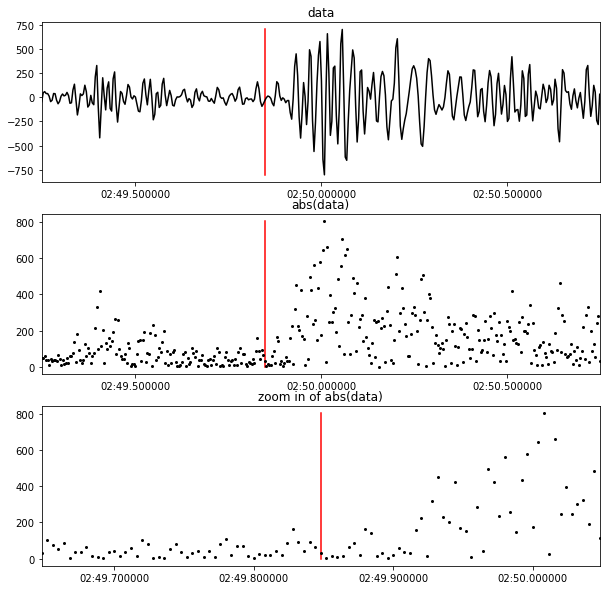

In [4]:
# identify the trace to inspect as an index into event_stream
index = 20 # test 0,2,16,20
trace = event_stream[index].copy()
# identify the pick time associated with this trace
pick_time_DT = event[index]['time'] # UTCDateTime object for operating on dates
pick_time = event[index]['time'].matplotlib_date # mpl date format for plotting

# get trace times and data
trace_times_DT = np.asarray([trace.stats.starttime + offset for offset in trace.times()])
trace_times = trace.times("matplotlib")
trace_data = trace.data.copy()

# plot trace data and the absolute value of the data
fig, ax = plt.subplots(3, figsize=(10, 10))

# plot the pick time
ax[0].plot_date([pick_time, pick_time], [trace_data.min(), trace_data.max()], fmt="r-", markersize=1)
# plot raw data as points
ax[0].plot_date(trace_times, trace_data, fmt="k-", markersize=1)
ax[0].set_title("data")
ax[0].set_xlim([trace_times[0], trace_times[-1]])

# plot the pick time
ax[1].plot_date([pick_time, pick_time], [abs(trace_data).min(), abs(trace_data).max()], fmt="r-", markersize=1)
# plot abs(data) as points
ax[1].plot_date(trace_times, abs(trace_data), fmt="ko", markersize=2)
ax[1].set_title("abs(data)")
ax[1].set_xlim([trace_times[0], trace_times[-1]])

# plot the pick time
ax[2].plot_date([pick_time, pick_time], [abs(trace_data).min(), abs(trace_data).max()], fmt="r-", markersize=1)
# plot zoom-in of abs(data)
ax[2].plot_date(trace_times, abs(trace_data), fmt="ko", markersize=2)
ax[2].set_title("zoom in of abs(data)")
# sex x_lim to + and - 0.2 seconds surrounding pick time
ax[2].set_xlim([(pick_time_DT - 0.2).matplotlib_date, (pick_time_DT + 0.2).matplotlib_date])

plt.show()

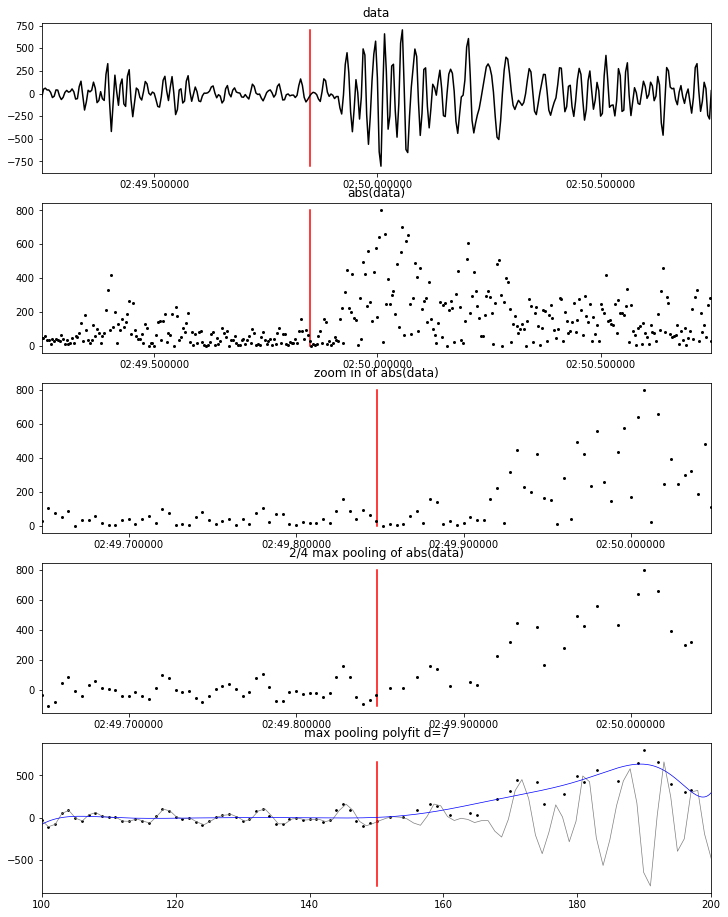

In [62]:
# this cell processes the trace data to ultimately determine a polynomial that describes the shape of the phase onset,
# then plots the data processing and fitting

# only considering data + and - 0.2 seconds from pick time
pick_time_index = (np.abs([data_time_DT - pick_time_DT for data_time_DT in trace_times_DT])).argmin() # get pick time index in data array
duration = 0.4 # s
sampling_rate = 250 # Hz

# initialize lists to store transformed data
max_pool_amplitude = []
max_pool_times = []
max_pool_indices = [] # this is used later for polynomial fitting

# make indices to loop over all data within 0.2s of pick time
starting_array_index = pick_time_index - int(duration / 2 * sampling_rate)
ending_array_index = pick_time_index + int(duration / 2 * sampling_rate)

# append all values before pick time
for index in range(starting_array_index, pick_time_index + 1):
    max_pool_amplitude.append(trace_data[index])
    max_pool_times.append(trace_times[index])
    max_pool_indices.append(index)
    
# after pick time, perform 2/4 max pooling on abs(data), so loop over remaining array in chunks of 4
for index in range(pick_time_index + 1, ending_array_index + 1, 4):
    # store a chunk of 4, data and times
    temp_data = abs(trace_data[index:index+4])
    temp_times = trace_times[index:index+4]
    # get indices of 2 max amplitude values from abs(data)
    top_2_indices = np.argpartition(temp_data, -2)[-2:]
    # append top 2 to the max_pool data lists
    for top_2_index in top_2_indices:
        max_pool_amplitude.append(abs(trace_data[top_2_index + index]))
        max_pool_times.append(trace_times[top_2_index + index])
        max_pool_indices.append(top_2_index + index)

# convert max_pool_amplitude to numpy array for plotting calls
max_pool_amplitude = np.asarray(max_pool_amplitude)

# fit a polynomial to the max pooled data using the indices as x values since polyfit hates mpl dates (small ranges)
p = np.poly1d(np.polyfit(max_pool_indices, max_pool_amplitude, 12))
t = np.linspace(max_pool_indices[0], max_pool_indices[-1], num=1000, endpoint=True)   
    
# plot 2/4 max pooling and trace data as above for reference
fig, ax = plt.subplots(5, figsize=(12, 16))

# plot the pick time
ax[0].plot_date([pick_time, pick_time], [trace_data.min(), trace_data.max()], fmt="r-", markersize=1)
# plot raw data
ax[0].plot_date(trace_times, trace_data, fmt="k-", markersize=1)
ax[0].set_title("data")
ax[0].set_xlim([trace_times[0], trace_times[-1]])

# plot the pick time
ax[1].plot_date([pick_time, pick_time], [abs(trace_data).min(), abs(trace_data).max()], fmt="r-", markersize=1)
# plot abs(data) as points
ax[1].plot_date(trace_times, abs(trace_data), fmt="ko", markersize=2)
ax[1].set_title("abs(data)")
ax[1].set_xlim([trace_times[0], trace_times[-1]])

# plot the pick time
ax[2].plot_date([pick_time, pick_time], [abs(trace_data).min(), abs(trace_data).max()], fmt="r-", markersize=1)
# plot zoom-in of abs(data)
ax[2].plot_date(trace_times, abs(trace_data), fmt="ko", markersize=2)
ax[2].set_title("zoom in of abs(data)")
# sex x_lim to + and - 0.2 seconds surrounding pick time
ax[2].set_xlim([(pick_time_DT - 0.2).matplotlib_date, (pick_time_DT + 0.2).matplotlib_date])

# plot the pick time
ax[3].plot_date([pick_time, pick_time], [max_pool_amplitude.min(), max_pool_amplitude.max()], fmt="r-", markersize=1)
# plot max_pool transformed data
ax[3].plot_date(max_pool_times, max_pool_amplitude, fmt="ko", markersize=2)
ax[3].set_title("2/4 max pooling of abs(data)")
ax[3].set_xlim([(pick_time_DT - 0.2).matplotlib_date, (pick_time_DT + 0.2).matplotlib_date])

# plot the time series for reference
temp_xs = np.linspace(starting_array_index, ending_array_index, num=100)
temp_data = trace_data[starting_array_index:ending_array_index]
ax[4].plot(temp_xs, temp_data, c='gray', linewidth=0.7)
# plot the pick time
ax[4].plot([pick_time_index, pick_time_index], [temp_data.min(), temp_data.max()], c="r")
# plot max_pool transformed data
ax[4].scatter(max_pool_indices, max_pool_amplitude, s=3, c="k")
# plot the fit to the max_pool amplitude data
ax[4].plot(t, p(t), c="b", linewidth=0.7)
# sex x_lim to + and - 0.2 seconds surrounding pick time
ax[4].set_xlim([starting_array_index, ending_array_index])
ax[4].set_title("max pooling polyfit d=7")

plt.show()                                  

Text(0.5, 1.0, 'polyfit testing')

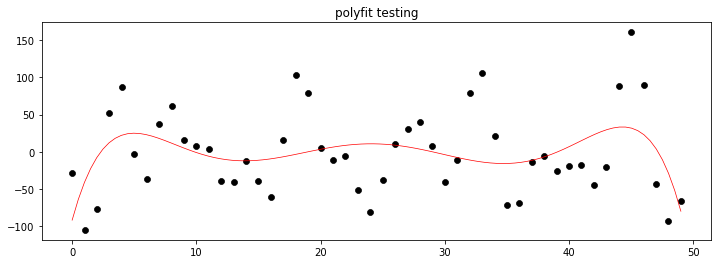

In [42]:
# sandbox for testing polyfit degree on different data

# dummy data
# x = [0, 1, 2, 3, 4, 5, 6, 8, 11, 12, 16]
# y = [1, 2, 1, 3, 1, 2, 6, 9, 10, 8, 14]

# subset of processed data
x = np.linspace(0, 49, num=50)
y = max_pool_amplitude[:50]

# fit and make polynomial of degree 6
p = np.poly1d(np.polyfit(x, y, 6))
t = np.linspace(x[0], x[-1], num=100, endpoint=True)

# plot data and fit
fig, ax = plt.subplots(1, figsize=(12, 4))
ax.plot(t, p(t), c="r", linewidth=0.7)
ax.scatter(x, y, c='k', linewidth=0.7)
ax.set_title("polyfit testing")

Text(0.5, 1.0, 'curvature of max pooling polyfit')

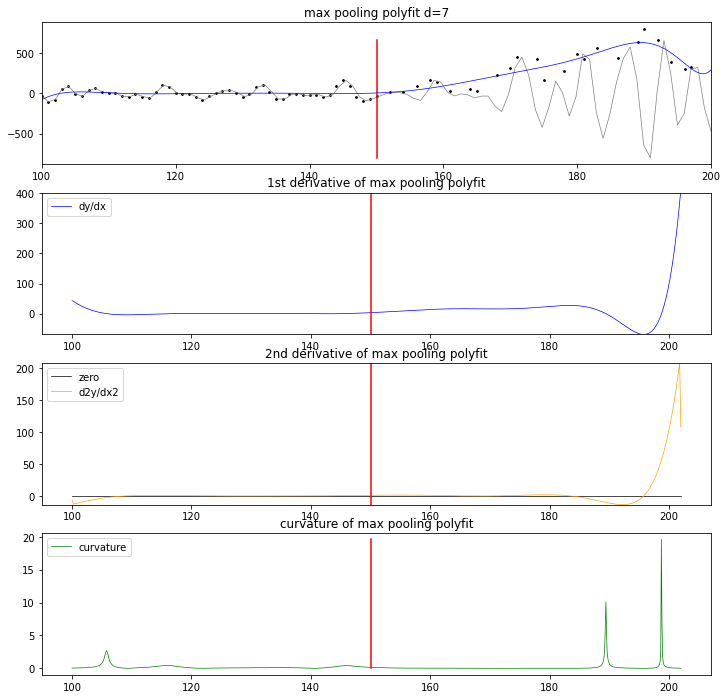

In [63]:
# calculate and plot first and second derivative, and curvature

# dy/dx first derivative
dy = np.gradient(p(t), t)
# d2y/dx2 second derivative
d2y = np.gradient(dy, t)
# calculate curvature
curvature = np.abs(d2y) / (np.sqrt(1 + dy ** 2)) ** 1.5

# plot max pooling, fit, and trace data as above for reference
fig, ax = plt.subplots(4, figsize=(12, 12))

# plot the time series for reference
ax[0].plot(temp_xs, temp_data, c='gray', linewidth=0.7)
# plot the pick time
ax[0].plot([pick_time_index, pick_time_index], [temp_data.min(), temp_data.max()], c="r")
# plot max_pool transformed data
ax[0].scatter(max_pool_indices, max_pool_amplitude, s=3, c="k")
# plot the fit to the max_pool amplitude data
ax[0].plot(t, p(t), c="b", linewidth=0.7)
# sex x_lim to + and - 0.2 seconds surrounding pick time
ax[0].set_xlim([starting_array_index, ending_array_index])
ax[0].set_title("max pooling polyfit d=7")

# plot first derivative
ax[1].plot(t, dy, c='blue', linewidth=0.7, label='dy/dx')
# plot the pick time
ax[1].plot([pick_time_index, pick_time_index], [dy.min(), dy.max()], c="r")
ax[1].legend()
ax[1].set_title("1st derivative of max pooling polyfit")
ax[1].set_ylim([dy.min(), dy.max()])

# plot zero line
ax[2].plot([t[0], t[-1]], [0, 0], c='black', linewidth=0.7, label='zero')
# plot second derivative
ax[2].plot(t, d2y, c='orange', linewidth=0.7, label='d2y/dx2')
# plot the pick time
ax[2].plot([pick_time_index, pick_time_index], [d2y.min(), d2y.max()], c="r")
ax[2].legend()
ax[2].set_title("2nd derivative of max pooling polyfit")
ax[2].set_ylim([d2y.min(), d2y.max()])

# plot the curvature
ax[3].plot(t, curvature, c='green', linewidth=0.7, label='curvature')
# plot the pick time
ax[3].plot([pick_time_index, pick_time_index], [curvature.min(), curvature.max()], c="r")
ax[3].legend()
ax[3].set_title("curvature of max pooling polyfit")

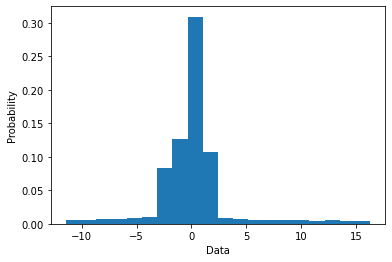

In [57]:
# plot histogram of d2y
plt.hist(d2y, density=True, bins=20)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data');